In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json

from torchvision.transforms import v2

from dataset import FacialKeypointsDataset
from model import get_model
from utils import load_model

In [2]:
run_name = "2023-11-10_14-50-51"

run_path = f"runs/{run_name}/"

train_summary = json.load(open(run_path + "train_summary.json"))

MODEL = train_summary["config"]["MODEL"]
IMAGE_SIZE = train_summary["config"]["IMAGE_SIZE"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = get_model(MODEL)
model = load_model(model, run_path + "best_model.pth")
model.to(DEVICE);

In [4]:
transforms_test = v2.Compose([
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
])


transforms_train = v2.Compose([
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float),
    v2.RandomRotation(degrees=(-25, 25)),
    v2.RandomAffine(degrees=(-15, 15), translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),
    v2.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0), antialias=True),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.RandomAutocontrast(p=0.2),
    v2.RandomEqualize(p=0.2),
])

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', 
                                    transform=transforms_test)

train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/',
                                    transform=transforms_train)



torch.Size([3, 224, 224]) torch.Size([136])


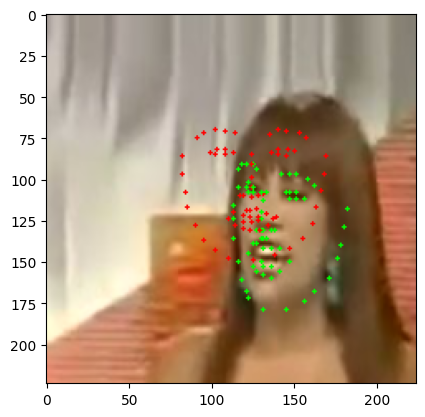

In [9]:
index = 5

image, keypoints = test_dataset[index]
print(image.shape, keypoints.shape)
keypoints = keypoints.reshape(-1, 2)

with torch.no_grad():
    model.eval()
    output = model(image.unsqueeze(0).to(DEVICE))
    output = output.cpu().numpy()
    output = output.reshape(-1, 2)


image = image.permute(1, 2, 0).numpy()
image = image.copy()

for i in range(keypoints.shape[0]):

    keypoints_y = int((keypoints[i, 1] + 1) * image.shape[1] / 2)
    keypoints_x = int((keypoints[i, 0] + 1) * image.shape[0] / 2)
    # keypoints_x = int(keypoints[i, 0])
    # keypoints_y = int(keypoints[i, 1])
    cv2.circle(image, (keypoints_x, keypoints_y), 1, (0, 1, 0), -1)
    
    # cv2.putText(image, str(i), (keypoints_x, keypoints_y), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0, 1, 0), 1)

    pred_y = int((output[i, 1] + 1) * image.shape[1] / 2)
    pred_x = int((output[i, 0] + 1) * image.shape[0] / 2)
    # pred_x = int(output[i, 0])
    # pred_y = int(output[i, 1])
    cv2.circle(image, (pred_x, pred_y), 1, (1, 0, 0), -1)

plt.imshow(image)

In [11]:
print(image.max(), image.min())

1.0000002 0.0
